### Libraries needs to be installed. Uncomment and execute as needed.

In [1]:
#!python -m pip install --upgrade pip

In [2]:
#!python -m pip install datasets

In [3]:
#!python -m pip install pytesseract

In [4]:
#!conda install pytesseract

In [5]:
#!python -m pip install opencv-contrib-python

In [6]:
#!python -m pip install pdf2image

 ###  As the end to end solution needs PDF as input, convert the image files to PDF format Its only one time task

### code to convert images to pdf

### code to scan and extract testing data in dataframe

### code to scan and extract testing data in dataframe

### Import custom library that contains functions to process the data

In [7]:
import pankaj_library as p


### import necessary libraries

In [8]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split  

pd.set_option('max_colwidth', -1)

<ipython-input-8-922d2289a39c>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


### define mapping of word to type (Header, Question, Answer or Other)

In [9]:
word_type_to_numeric = {'Other':0, 'Header':1, 'Question':2, 'Answer':3}
word_type_from_numeric = {val:key for key,val in word_type_to_numeric.items()}
word_type_from_numeric


{0: 'Other', 1: 'Header', 2: 'Question', 3: 'Answer'}

### Extraction data from PDF files takes long time (almost 1 hour), hence I extracted the data once and stored the data in the train.xls and test.xls. Provided the files with this notebook.

### Please change the paths below to use the files.

### If you want to invoke the full extraction, please remove or comment out the two lines, and the data will get extracted form pdf files

In [10]:
df_data_all_train = pd.read_excel('D:/Projects/NLP_BNY/dataset/train.xls')
df_data_all_test = pd.read_excel('D:/Projects/NLP_BNY/dataset/test.xls')

In [11]:
from pdf2image import convert_from_path
import pytesseract
import cv2

def extract_data(pdf_directory):
    df_data_all = pd.DataFrame()
    for root, dirs, files in os.walk(pdf_directory):
        for filename in files:
            filename=os.path.join(root, filename).replace('\\', '/')
            images = convert_from_path(filename)
            for image in images:
                df_data = pytesseract.image_to_data(image, lang='eng', output_type=pytesseract.Output.DATAFRAME)
                df_data_all = pd.concat([df_data_all, df_data])
                print(df_data_all.shape)
    df_data_all = df_data_all.dropna(subset=['text'])
    return df_data_all
            


### If you wish to execute extraction from PDF files (instead of using the train.xls and test.xls of extracted data), please update the folder path of pdf files for training and testing: train_directory and test_directory in below code

In [12]:
if 'df_data_all_train' not in globals():
    train_directory = 'D:/Projects/NLP_BNY/dataset/training_data/pdfs'
    print('extracting data from pdf files in directory: ' + train_directory)
    df_data_all_train = extract_data(train_directory)
else:
    print('training data already loaded')
    
    
if 'df_data_all_test' not in globals():
    test_directory = 'D:/Projects/NLP_BNY/dataset/testing_data/pdfs'
    print('extracting data from pdf files in directory: ' + test_directory)
    df_data_all_test = extract_data(test_directory)
else:
    print('testing data already loaded')

    

training data already loaded
testing data already loaded


### transform the loaded data into the dataframe with expected column names

In [13]:
df_data_all_train = df_data_all_train.dropna(subset=['text'])
df_train = df_data_all_train.loc[:, ['text']]
df_train.rename(columns={'text':'word'}, inplace=True)
df_train.loc[:, ['x1']] = df_data_all_train['left']
df_train.loc[:, ['y1']] = df_data_all_train['top']
df_train.loc[:, ['x2']] = df_data_all_train['left'] + df_data_all_train['width']
df_train.loc[:, ['y2']] = df_data_all_train['top'] + df_data_all_train['height']

In [14]:
df_train.head()

,word,x1,y1,x2,y2
0,,0,0,1988,552
1,R&D,718,570,775,594
2,QUALITY,796,566,931,597
3,IMPROVEMENT,953,563,1164,589
4,SUGGESTION/SCLUTION,710,602,1077,636


###  Preprocess the data and generate the ground truth labels

In [15]:
df_train = p.pre_prcess(df_train)

In [16]:
df_train.head()

,word,x1,y1,x2,y2,has_colon,char_case,ner_calc
0,,0,0,1988,552,0,0,3
1,r&d,718,570,775,594,0,2,1
2,quality,796,566,931,597,0,2,1
3,improvement,953,563,1164,589,0,2,1
4,suggestion/sclution,710,602,1077,636,1,2,2


In [17]:
y_column = 'ner_calc'
X_columns = ['word', 'x1', 'y1', 'x2', 'y2', 'has_colon', 'char_case']

X = df_train[X_columns]
y = df_train[y_column]


### Split train data into train set and validation set

In [18]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size= 0.01, random_state=0)  

### add a default entry of 'other' to map non-existing words, to avoid failure in one hot encoding

In [19]:
X_train_values = X_train.values.tolist()
X_train_values.append(['other', 0, 0, 0, 0, 0, 3])
y_train = y_train.append(pd.Series([3]))

X_train = pd.DataFrame(X_train_values, columns=X_train.columns)
X_train

,word,x1,y1,x2,y2,has_colon,char_case
0,at,528,1301,561,1328,1,0
1,pages,664,1166,778,1195,0,2
2,tennessee,1547,1028,1734,1070,0,1
3,134-04,1827,110,1880,125,0,0
4,title,1164,2132,1298,2161,0,0
...,...,...,...,...,...,...,...
22131,on,1610,863,1647,886,0,0
22132,temperature.,1284,1171,1548,1196,0,0
22133,bc20-48,629,1562,788,1588,0,2
22134,1,424,1771,438,1796,0,0


### Transform the training data as One hot encoding, scaling etc

In [20]:
X_train = p.process(X_train, is_train=True)

### Transform the validation data same as training data above

In [21]:
X_val = p.process(X_val, is_train=False)

D:\Programs\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Define various models and add them into the list. SVC model is taking lot of time for processing and couldn't complete on local, hence excluded from the list of models below

In [22]:
clf_decision_tree= DecisionTreeClassifier(criterion='entropy', random_state=0)  
clf_random_forest = RandomForestClassifier()
clf_svc = SVC(kernel='linear', random_state=0)  
clf_gnb = GaussianNB()

models_list = [clf_decision_tree, clf_random_forest, clf_gnb]



### Train the models in the list above

In [23]:
print('Training models:')
for model in models_list:
    p.train_models(model, X_train, y_train)

Training models:
Fitting model: DecisionTreeClassifier
Fitting model: RandomForestClassifier
Fitting model: GaussianNB


### Evaluate model performance against validation dataset

In [24]:
print('Performance Metrics for Validation Dataset: \n')        
p.evaluate_models(models_list, X_val, y_val)




Performance Metrics for Validation Dataset: 

Evaluating model: DecisionTreeClassifier
Evaluating model: RandomForestClassifier
Evaluating model: GaussianNB


,accuracy,f1_score (header),f1_score (question),f1_score (answer),precision (header),precision (question),precision (answer)
DecisionTreeClassifier,0.982143,0.957447,1.0,0.987805,0.918367,1.0,1.000000
RandomForestClassifier,0.977679,0.947368,1.0,0.984709,0.900000,1.0,1.000000
GaussianNB,0.441964,0.413146,1.0,0.401914,0.261905,1.0,0.976744


### Perform the exact same steps on testing data that were carried out on training dataset earlier

In [25]:
df_data_all_test = df_data_all_test.dropna(subset=['text'])
df_test = df_data_all_test.loc[:, ['text']]
df_test.rename(columns={'text':'word'}, inplace=True)
df_test.loc[:, ['x1']] = df_data_all_test['left']
df_test.loc[:, ['y1']] = df_data_all_test['top']
df_test.loc[:, ['x2']] = df_data_all_test['left'] + df_data_all_test['width']
df_test.loc[:, ['y2']] = df_data_all_test['top'] + df_data_all_test['height']

In [26]:
display(df_test.head())
df_test = p.pre_prcess(df_test)
display(df_test.head())
X_test = df_test[X_columns]
y_test = df_test[y_column]

X_test = p.process(X_test, is_train=False)

,word,x1,y1,x2,y2
0,,34,357,401,592
1,Me,1325,163,1355,185
2,ATT.,289,244,352,271
3,GEN.,379,243,441,271
4,ADMIN.,453,236,564,283


,word,x1,y1,x2,y2,has_colon,char_case,ner_calc
0,,34,357,401,592,0,0,3
1,me,1325,163,1355,185,0,1,1
2,att.,289,244,352,271,0,2,3
3,gen.,379,243,441,271,0,2,3
4,admin.,453,236,564,283,0,2,3


D:\Programs\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Evaluate model performance against testing dataset

In [27]:
print('Performance Metrics for Test Dataset: \n')  
p.evaluate_models(models_list, X_test, y_test)
      


Performance Metrics for Test Dataset: 

Evaluating model: DecisionTreeClassifier
Evaluating model: RandomForestClassifier
Evaluating model: GaussianNB


,accuracy,f1_score (header),f1_score (question),f1_score (answer),precision (header),precision (question),precision (answer)
DecisionTreeClassifier,0.978070,0.956107,1.0,0.984230,0.927043,1.0,0.995443
RandomForestClassifier,0.977569,0.955704,1.0,0.983791,0.915166,1.0,1.000000
GaussianNB,0.414286,0.428047,1.0,0.323785,0.280244,1.0,0.860108


### Plot confusion matrix for all models on testing dataset

Plotting for model: DecisionTreeClassifier
confusion matrix:


array([[1906,    0,   25],
       [   0,  438,    0],
       [ 150,    0, 5461]], dtype=int64)

multilabel confusion matrix:


array([[[7980,    0],
        [   0,    0]],

       [[5899,  150],
        [  25, 1906]],

       [[7542,    0],
        [   0,  438]],

       [[2344,   25],
        [ 150, 5461]]], dtype=int64)

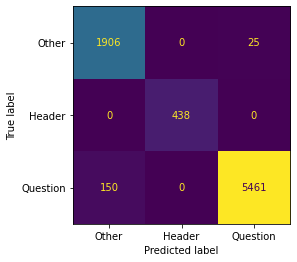

Plotting for model: RandomForestClassifier
confusion matrix:


array([[1931,    0,    0],
       [   0,  438,    0],
       [ 179,    0, 5432]], dtype=int64)

multilabel confusion matrix:


array([[[7980,    0],
        [   0,    0]],

       [[5870,  179],
        [   0, 1931]],

       [[7542,    0],
        [   0,  438]],

       [[2369,    0],
        [ 179, 5432]]], dtype=int64)

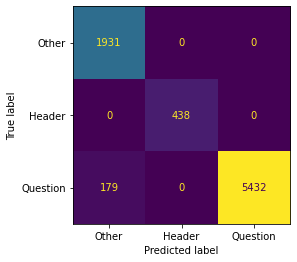

Plotting for model: GaussianNB
confusion matrix:


array([[1749,    0,  182],
       [   0,  438,    0],
       [4492,    0, 1119]], dtype=int64)

multilabel confusion matrix:


array([[[7980,    0],
        [   0,    0]],

       [[1557, 4492],
        [ 182, 1749]],

       [[7542,    0],
        [   0,  438]],

       [[2187,  182],
        [4492, 1119]]], dtype=int64)

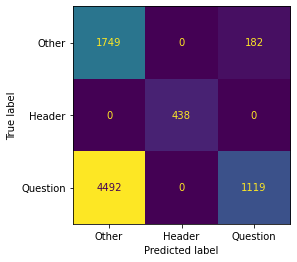

In [28]:
for model in models_list:
    p.plot_confusion_matrix_for_models(model, X_test, y_test)


In [29]:
p.word_type_from_numeric = word_type_from_numeric
p.X_columns = X_columns

### example word predictions using the trained models

In [30]:
to_predict = {'word':'R&D', 'x1':200, 'y1':350, 'x2':300, 'y2':400} 
p.predict_word_type(models_list, to_predict)



,Word,model name,Predicted Type
1,R&D,DecisionTreeClassifier,Header
2,R&D,RandomForestClassifier,Header
3,R&D,GaussianNB,Header


### another example word prediction using the trained models

In [31]:
to_predict = {'word':'Submission', 'x1':100, 'y1':600, 'x2':150, 'y2':650} 
p.predict_word_type(models_list, to_predict)

,Word,model name,Predicted Type
1,Submission,DecisionTreeClassifier,Answer
2,Submission,RandomForestClassifier,Answer
3,Submission,GaussianNB,Header
